In [4]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import datasets
diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
GradientBoostingRegressor(random_state=0)
reg.predict(X_test[0].reshape(1,-1))[0]

255.26058696768413

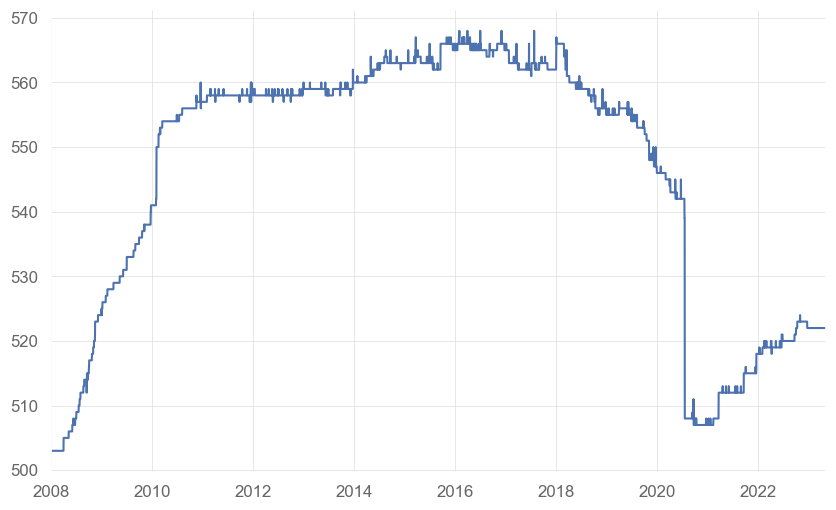

In [5]:
universe = master.baskets.get_index_historical_components('GSPC')
P = func.presence_matrix(universe).loc['2008':]
P.sum(1).plot()
market_data = pd.read_parquet('data/US/mkt_data.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()

In [6]:
earnings = pd.read_parquet('data/US/earnings.pq')
earnings['Date'] = pd.to_datetime(earnings['reportDate'])
earnings = earnings.droplevel(0).set_index('Date',append=True)
earnings = earnings.reorder_levels(['Date','Ticker'])
earnings = earnings[~earnings.index.duplicated(keep='first')]
earnings = earnings[earnings['epsActual'].notna()]

balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
balance_sheet['Date'] = pd.to_datetime(balance_sheet['filing_date'])
balance_sheet = balance_sheet.droplevel(0).set_index('Date',append=True)
balance_sheet = balance_sheet.reorder_levels(['Date','Ticker'])
balance_sheet = balance_sheet[~balance_sheet.index.duplicated(keep='first')]

cash_flow = pd.read_parquet('data/US/cash_flow.pq')
cash_flow['Date'] = pd.to_datetime(cash_flow['filing_date'])
cash_flow = cash_flow.droplevel(0).set_index('Date',append=True)
cash_flow = cash_flow.reorder_levels(['Date','Ticker'])
cash_flow = cash_flow[~cash_flow.index.duplicated(keep='first')]


income_statement = pd.read_parquet('data/US/income_statement.pq')
income_statement['Date'] = pd.to_datetime(income_statement['filing_date'])
income_statement = income_statement.droplevel(0).set_index('Date',append=True)
income_statement = income_statement.reorder_levels(['Date','Ticker'])
income_statement = income_statement[~income_statement.index.duplicated(keep='first')]
income_statement

,,date,filing_date,currency_symbol,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,netIncome,sellingGeneralAdministrative,sellingAndMarketingExpenses,...,otherItems,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,preferredStockAndOtherAdjustments
Date,Ticker,,,,,,,,,,,,,,,,,,,,,
1999-01-31,A,1999-01-31,1999-01-31,USD,None,None,None,None,74000000.00,None,None,...,None,None,1786000000.00,None,None,None,None,None,None,None
1999-04-30,A,1999-04-30,1999-04-30,USD,None,None,None,None,157000000.00,None,None,...,None,None,2010000000.00,None,None,None,None,None,None,None
1999-07-31,A,1999-07-31,1999-07-31,USD,None,None,None,None,135000000.00,None,None,...,None,None,2087000000.00,None,None,None,None,None,None,None
1999-10-31,A,1999-10-31,1999-10-31,USD,None,None,None,None,146000000.00,None,None,...,None,None,2448000000.00,None,None,None,None,None,None,None
2000-03-15,A,2000-01-31,2000-03-15,USD,290000000.00,0.00,202000000.00,0.00,131000000.00,625000000.00,None,...,0.00,71000000.00,2246000000.00,915000000.00,1160000000.00,31000000.00,0.00,0.00,88000000.00,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-15,ZTS,2021-12-31,2022-02-15,USD,138000000.00,None,506000000.00,-1000000.00,414000000.00,593000000.00,None,...,None,93000000.00,1967000000.00,771000000.00,600000000.00,-90000000.00,None,413000000.00,414000000.00,None
2022-05-05,ZTS,2022-03-31,2022-05-05,USD,122000000.00,None,727000000.00,-1000000.00,595000000.00,465000000.00,None,...,None,133000000.00,1986000000.00,628000000.00,569000000.00,-62000000.00,None,594000000.00,595000000.00,None
2022-08-04,ZTS,2022-06-30,2022-08-04,USD,135000000.00,None,670000000.00,0.00,529000000.00,529000000.00,None,...,None,141000000.00,2052000000.00,701000000.00,625000000.00,-56000000.00,None,529000000.00,529000000.00,None


## Financial ratios :

- Net Debt / cash
- Debt-to-Equity Ratio: Total Debt / Total Equity
- Return on Equity (ROE): Net Income / Total Equity
- Return on Assets (ROA): Net Income / Total Assets
- Gross Profit Margin: (Total Revenue - Cost of Goods Sold) / Total Revenue
- Operating Profit Margin: Operating Income / Total Revenue
- Net Profit Margin: Net Income / Total Revenue
- Current Ratio: Current Assets / Current Liabilities
- Quick Ratio: (Current Assets - Inventory) / Current Liabilities
- Accounts Receivable Turnover: Total Revenue / Average Accounts Receivable
- Inventory Turnover: Cost of Goods Sold / Average Inventory
- Asset Turnover Ratio: Total Revenue / Total Assets
- Price-to-Earnings Ratio (P/E Ratio): Price per Share / Earnings per Share
- Dividend Yield: Annual Dividend per Share / Price per Share
- Price-to-Book Ratio (P/B Ratio): Price per Share / Book Value per Share
- Return on Investment (ROI): (Net Income + Interest Expense) / Total Assets
- Price/Earnings to Growth (PEG) Ratio: P/E Ratio / Annual Earnings per Share Growth Rate
- Price/Sales (P/S) Ratio: Market Capitalization / Total Revenue
- EBITDA Margin: EBITDA / Total Revenue
- EBITDA Coverage Ratio: EBITDA / Interest Expense
- Free Cash Flow (FCF) Yield: FCF per Share / Stock Price
- Return on Invested Capital (ROIC): EBIT / (Total Equity + Total Debt - Cash and Equivalents)
- Earnings Before Interest, Taxes, Depreciation, and Amortization per Share (EBITDA/Share): EBITDA / Shares Outstanding
- Price-to-Operating Cash Flow Ratio: Price per Share / Operating Cash Flow per Share
- Earnings Yield: Earnings per Share / Price per Share
- Debt-to-EBITDA Ratio: Total Debt / EBITDA


In [7]:
net_debt = balance_sheet['netDebt'].unstack().reindex_like(P).ffill().astype(float)
cash = balance_sheet['cash'].unstack().reindex_like(P).ffill().astype(float)

debt_cash = (net_debt/ cash).stack()
debt_cash

            Ticker
2008-01-03  CAG       27.981265
2008-01-04  CAG       27.981265
            CTAS      15.751359
            DRI       69.924915
2008-01-07  CAG       27.981265
                        ...    
2023-04-06  YUM       31.291553
            ZBH       14.162364
            ZBRA      19.590476
            ZION      -0.041562
            ZTS        0.882156
Length: 2478545, dtype: float64

In [8]:
total_debt =balance_sheet['shortLongTermDebtTotal'].unstack().reindex_like(P).ffill().astype(float)
total_equity = balance_sheet['commonStockTotalEquity'].unstack().reindex_like(P).ffill().astype(float)
debt_equity = (total_debt/total_equity).stack()

In [9]:
net_income = income_statement['netIncome'].unstack().reindex_like(P).ffill().astype(float)
total_assets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
roa = (net_income/total_assets).stack()


In [10]:
roe =  (net_income/ total_equity).stack()

In [11]:
total_revenue = income_statement['totalRevenue'].unstack().reindex_like(P).ffill().astype(float)
cost_revenue = income_statement['costOfRevenue'].unstack().reindex_like(P).ffill().astype(float)
gross_margin = ((total_revenue - cost_revenue)/ total_revenue).stack()


In [14]:
total_revenue = income_statement['totalRevenue'].unstack().reindex_like(P).ffill().astype(float)
cost_revenue = income_statement['costOfRevenue'].unstack().reindex_like(P).ffill().astype(float)

operating_profit = income_statement['operatingIncome'].unstack().reindex_like(P).ffill().astype(float)
operating_margin = (operating_profit / total_revenue).stack()

In [ ]:
current_assets = balance_sheet['totalCurrentAssets'].unstack().reindex_like(P).ffill().astype(float)
current_liab = balance_sheet['totalCurrentLiabilities'].unstack().reindex_like(P).ffill().astype(float)
current_ratio = (current_assets/ current_liab).stack()

In [ ]:
inventory = balance_sheet['inventory'].unstack().reindex_like(P).ffill().astype(float)
quick_ratio = ((current_assets - inventory)/ current_liab).stack()

In [ ]:
asset_turnover_ratio = (total_assets/ total_revenue).stack()

In [ ]:
price = market_data['close'].unstack().reindex_like(P).ffill().astype(float)
eps =  earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
pe_ratio = (price/eps).stack()

In [ ]:
mkt_cap = market_data['MktCap'].unstack().reindex_like(P).ffill().astype(float)
ps_ratio = (mkt_cap/total_revenue).stack()

In [ ]:
earnings_yield = (eps/price).stack()

In [ ]:
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
debt_to_ebitda = (total_debt/ebitda).stack()

In [ ]:
shares = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill().astype(float)
ebitda_share = (ebitda/shares).stack()

In [13]:
ebit = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalCurrentAssets = balance_sheet['totalCurrentAssets'].unstack().reindex_like(P).ffill().astype(float)
roic = (ebit/(totalAssets - totalCurrentAssets)).stack()


In [ ]:
totalAssets = balance_sheet['totalAssets'].unstack().reindex_like(P).ffill().astype(float)
totalLiabilities = balance_sheet['totalLiab'].unstack().reindex_like(P).ffill().astype(float)
book_value = totalAssets - totalLiabilities
shares = balance_sheet['commonStockSharesOutstanding'].unstack().reindex_like(P).ffill().astype(float)
book_value_share = book_value/ shares
close = market_data['close'].unstack().reindex_like(P).astype(float)
pb_ratio = (close/book_value_share).stack()

In [ ]:
eps_actual = earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
eps_estimate = earnings['epsEstimate'].unstack().reindex_like(P).ffill().astype(float)
eps_surprise = (eps_actual - eps_estimate).stack()

In [ ]:
ratios = {
        'eps_surprise':eps_surprise,
        'pb_ratio':pb_ratio,
        'roic': roic,
        'ebitda_share':ebitda_share,
        'debt_to_ebitda': debt_to_ebitda,
        'earnings_yield': earnings_yield,
        'ps_ratio':ps_ratio,
        'pe_ratio':pe_ratio,
        'asset_turnover_ratio':asset_turnover_ratio,
        'quick_ratio':quick_ratio,
        'current_ratio':current_ratio,
        'operating_margin':operating_margin,
        'gross_margin':gross_margin,
        'roe':roe,
        'roa':roa,
        'debt_equity':debt_equity,
        'debt_cash':debt_cash

        }

In [ ]:
result_df = pd.DataFrame()

# Iterate through the dictionary and add each DataFrame as a new column
for key, df in ratios.items():
    print(key)
    df = pd.DataFrame({key:df})
    df.index.names = ['Date','Ticker']

    # Unstack the MultiIndex to create columns for each level
    # Append the DataFrame to the result DataFrame
    ratios[key] = df

# Print the result DataFrame
print(result_df)

In [ ]:
data_raw = pd.DataFrame( {'close':market_data['close'].unstack().reindex_like(P).stack()})
features = list(ratios)
for col in tqdm(features):
    data_raw[col] = ratios[col]

data_raw

In [ ]:
data_scale = data_raw.copy()
for column in tqdm(features) :
    sub_df = data_raw[column].unstack().reindex_like(P).ffill()
    sub_df_rank_cs = sub_df[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).round(2)
    sub_df_rank_cs = sub_df_rank_cs.fillna(sub_df_rank_cs.mean(1))[P]
    data_scale[column+'_cs'] = sub_df_rank_cs.stack()
    sub_df_rank_ts = sub_df_rank_cs.rolling(252,min_periods=10).rank(pct=True,ascending=True).clip(0.01,0.99).round(2)
    sub_df_rank_ts = sub_df_rank_ts.fillna(sub_df_rank_ts.mean(1))[P]
    data_scale[column+'_ts'] = sub_df_rank_ts.stack()
    data_scale.drop(column,axis=1,inplace=True)
data_model = data_scale.dropna()



In [ ]:
# data_model.to_parquet('data_model.pq')
data_model = pd.read_parquet('data/US/data_model.pq')
# data_model['close']= R[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf).round(2).stack()
data_model['close'] = market_data['close']
data_model = data_model.dropna()

In [ ]:
Y = data_model.iloc[:,0]
X= data_model.iloc[:,1:]
X_train = X.loc[:'2018']
Y_train = Y.loc[:'2018']
X_test = X.loc['2018':]
Y_test = Y.loc['2018':]
Y_test

In [ ]:
dates_test = pd.to_datetime(X.loc['2022':].index.get_level_values(0)).unique()
results = {}
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
result = pd.DataFrame().reindex_like(P)
for i,date in (enumerate(tqdm(dates_test[1:-1]))):
    curr_date = str(date.date())
    next_date = str(dates_test[i+1].date())
    X_train = X.loc[:curr_date]
    Y_train = Y.loc[:curr_date]
    tickers = X_train.loc[curr_date].index.tolist()
    for ticker in tickers:
        try :
            x_train = X_train.xs(ticker,level=1)
            y_train = Y_train.xs(ticker,level=1)
            neigh = KNeighborsRegressor(n_neighbors=10).fit(x_train,y_train)
            pred = neigh.predict(pd.DataFrame(X_train.loc[(curr_date,ticker)]).T)[0]
        except :
            pred = np.nan
        result.loc[next_date,ticker] = pred

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(df['true'],df['pred'])

In [ ]:
for ticker in result.columns.tolist():
    df = pd.DataFrame({'true':close[ticker],'pred':result[ticker]}).dropna()
    df.plot(title=ticker+'   '+ str(r2_score(df['true'],df['pred'])))
    plt.show()


In [ ]:
df.corr()

In [ ]:
str(curr_date.date())

In [ ]:
result = pd.DataFrame().reindex_like(P)
for i,date in (enumerate(tqdm(dates_test[1:-1]))):
    curr_date = date
    previous_date = dates_test[i-1]
    next_date = dates_test[i+1]
    X_train = X.loc[:previous_date]
    Y_train = Y.loc[:previous_date]
    tickers = X_train.loc[previous_date].index.tolist()
    for ticker in tickers:
        x_train = X_train.xs(ticker,level=1)
        y_train = Y_train.xs(ticker,level=1)
        neigh = KNeighborsRegressor(n_neighbors=5).fit(x_train,y_train)
        pred = neigh.predict(pd.DataFrame(X.loc[(curr_date,ticker)]).T)[0]

        result.loc[curr_date,ticker] = pred


In [ ]:
tickers = X_train.loc[previous_date].index.tolist()
for ticker in tickers:
    x_train = X_train.xs(ticker,level=1)
    y_train = Y_train.xs(ticker,level=1)
    neigh = KNeighborsRegressor(n_neighbors=5).fit(x_train,y_train)
    pred = neigh.predict(pd.DataFrame(X.loc[(curr_date,ticker)]).T)[0]

    result.loc[curr_date,ticker] = pred


In [ ]:
neigh = KNeighborsRegressor(n_neighbors=5).fit(x_train,y_train)
pred = neigh.predict(X.loc[curr_date].loc(ticker))

In [ ]:
pred = neigh.predict(pd.DataFrame(X.loc[(curr_date,ticker)]).T)[0]
true = Y.loc[(next_date,ticker)]
pred

In [ ]:
signal = pd.DataFrame(results).T.reindex_like(P)[P].dropna(0,'all')
signal = signal[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.5] = None
signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center)
signal = signal[P].div(signal.abs().sum(1),0)

pnl = (signal[P].shift()*R).dropna(0,'all').sum(1)
sr = sharpe(pnl)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
pnl.cumsum().plot()
plt.ylabel('pnl')
pd.Series({'Sharpe':sr,'Turnover':turnover,'biais':pnl.mean()*1e4}).round(1)

In [ ]:
0.04*(253/34)*3